## Import

In [16]:
import os
import torch
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, Trainer, AutoTokenizer
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score,classification_report
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer


In [17]:
# Cuda pruefen
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


## import der gelablten daten und testsplit

Gelabelte Daten importieren und mergen

In [18]:
DATA_PATH = '../../data/processed/'

In [19]:
# CSV-Dateien laden aus dem definierten Verzeichnis
df_posts_old = pd.read_csv(DATA_PATH + "labeled_posts.csv").rename(columns={"post_id": "id"})
df_comments_old = pd.read_csv(DATA_PATH + "labeled_comments.csv").rename(columns={"comment_id": "id"})
df_new_posts = pd.read_csv(DATA_PATH + "labeled_post.csv").rename(columns={"post_id": "id"})
df_new_comments = pd.read_csv(DATA_PATH + "labeled_comment.csv").rename(columns={"comment_id": "id"})

# Alle 4 Datasets zusammenfassen → 600 Samples
df_all_labeled = pd.concat([df_posts_old, df_comments_old, df_new_posts, df_new_comments], ignore_index=True)
df_all_labeled = df_all_labeled[['id', 'text', 'label']].dropna()
df_all_labeled['label'] = pd.to_numeric(df_all_labeled['label'], errors='coerce')
df_all_labeled = df_all_labeled.dropna(subset=['label'])
df_all_labeled['label'] = df_all_labeled['label'].astype(int)

print(f"✅ Gesamtdatensatz mit {len(df_all_labeled)} gelabelten Beispielen bereit.")
# 🔍 Anzeigen
print(df_all_labeled["label"].value_counts())

✅ Gesamtdatensatz mit 574 gelabelten Beispielen bereit.
label
1    300
0    186
2     88
Name: count, dtype: int64


train test split

In [20]:
# 📌 Ziel: So viele wie möglich → n = Anzahl der kleinsten Klasse
n_per_class = df_all_labeled["label"].value_counts().min()

# ➖ Testset: Gleich viele pro Klasse
df_balanced_test = (
    df_all_labeled
    .groupby("label", group_keys=False)
    .apply(lambda x: x.sample(n=n_per_class, random_state=42))
    .reset_index(drop=True)
)

# ➕ Restliche Daten für Training/Val
df_rest = df_all_labeled.drop(df_balanced_test.index).reset_index(drop=True)

print(df_balanced_test["label"].value_counts())
print(f"📊 Balanciertes Testset erstellt: {len(df_balanced_test)} Beispiele")


label
0    88
1    88
2    88
Name: count, dtype: int64
📊 Balanciertes Testset erstellt: 264 Beispiele


C:\Users\hp\AppData\Local\Temp\ipykernel_22416\3691539362.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all_labeled


Modellpfade

In [21]:
EXPERIMENTS_BASE_PATH = "../../models/experiments/"

MODEL_PATHS = {
    "deberta": os.path.join(EXPERIMENTS_BASE_PATH, "deberta"),
    "cryptobert_elkulako": os.path.join(EXPERIMENTS_BASE_PATH, "cryptobert_elkulako"),
    "vader": os.path.join(EXPERIMENTS_BASE_PATH, "vader"),
    "textblob": os.path.join(EXPERIMENTS_BASE_PATH, "textblob")
}

# Verzeichnisse erstellen
for path in MODEL_PATHS.values():
    os.makedirs(path, exist_ok=True)


## de Berta Modell

In [28]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=3)

test_dataset = Dataset.from_pandas(df_balanced_test)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test = tokenized_test.rename_column("label", "labels")
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

trainer = Trainer(model=model, tokenizer=tokenizer)
predictions = trainer.predict(tokenized_test)

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

acc_deberta = accuracy_score(y_true, y_pred)
f1_deberta = f1_score(y_true, y_pred, average="macro")

print("Accuracy:", acc_deberta)
print("F1 (macro):", f1_deberta)
print("Classification Report:")
print(classification_report(y_true, y_pred))

model.save_pretrained(MODEL_PATHS["deberta"])
tokenizer.save_pretrained(MODEL_PATHS["deberta"])



c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 264/264 [00:00<00:00, 3669.24 examples/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_22416\2432194583.py:13: FutureW

Accuracy: 0.3371212121212121
F1 (macro): 0.17463213717895365
Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50        88
           1       1.00      0.01      0.02        88
           2       0.00      0.00      0.00        88

    accuracy                           0.34       264
   macro avg       0.44      0.34      0.17       264
weighted avg       0.44      0.34      0.17       264



c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


('../../models/experiments/deberta\\tokenizer_config.json',
 '../../models/experiments/deberta\\special_tokens_map.json',
 '../../models/experiments/deberta\\spm.model',
 '../../models/experiments/deberta\\added_tokens.json',
 '../../models/experiments/deberta\\tokenizer.json')

## ElKulako/cryptobert

In [23]:
# Modell und Tokenizer laden
model_name = "ElKulako/cryptobert"
cryptobert_tokenizer = AutoTokenizer.from_pretrained(model_name)
cryptobert_model = AutoModelForSequenceClassification.from_pretrained(model_name)
cryptobert_model.eval()

# Texte & Labels aus Testdaten extrahieren
texts = test_dataset["text"]
true_labels = test_dataset["label"]

# Vorhersagen generieren
preds = []
for text in texts:
    inputs = cryptobert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        logits = cryptobert_model(**inputs).logits
    pred_id = torch.argmax(logits, dim=1).item()
    preds.append(pred_id)

# Label-Mapping: CryptoBERT: 0=neg, 1=neutral, 2=pos → eigene Zuordnung: 2=neg, 1=neutral, 0=pos
label_mapping = {2: 0, 1: 1, 0: 2}
mapped_preds = [label_mapping[p] for p in preds]

# Evaluation
acc_elkulako = accuracy_score(true_labels, mapped_preds)
f1_elkulako = f1_score(true_labels, mapped_preds, average="macro")

print(f"CryptoBERT (ElKulako) — Accuracy: {acc_elkulako:.4f}, F1: {f1_elkulako:.4f}")

# Modell speichern
cryptobert_model.save_pretrained(MODEL_PATHS["cryptobert_elkulako"])
cryptobert_tokenizer.save_pretrained(MODEL_PATHS["cryptobert_elkulako"])


CryptoBERT (ElKulako) — Accuracy: 0.4129, F1: 0.3934


('../../models/experiments/cryptobert_elkulako\\tokenizer_config.json',
 '../../models/experiments/cryptobert_elkulako\\special_tokens_map.json',
 '../../models/experiments/cryptobert_elkulako\\vocab.json',
 '../../models/experiments/cryptobert_elkulako\\merges.txt',
 '../../models/experiments/cryptobert_elkulako\\added_tokens.json',
 '../../models/experiments/cryptobert_elkulako\\tokenizer.json')

## Vader

In [24]:
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, f1_score
import json

# Zentral definierter Speicherpfad
EXPERIMENTS_BASE_PATH = "../../models/experiments/"
MODEL_NAME = "vader"
SAVE_PATH = os.path.join(EXPERIMENTS_BASE_PATH, MODEL_NAME)
os.makedirs(SAVE_PATH, exist_ok=True)

# Initialisierung
vader = SentimentIntensityAnalyzer()

# Vorhersage
vader_preds = []
for text in test_dataset["text"]:
    score = vader.polarity_scores(text)["compound"]
    if score >= 0.05:
        vader_preds.append(0)  # bullish
    elif score <= -0.05:
        vader_preds.append(2)  # bearish
    else:
        vader_preds.append(1)  # neutral

# Evaluation
true_labels = test_dataset["label"]
acc_vader = accuracy_score(true_labels, vader_preds)
f1_vader = f1_score(true_labels, vader_preds, average="macro")

print(f"VADER — Accuracy: {acc_vader:.4f}, F1: {f1_vader:.4f}")

# Konfiguration speichern
config = {
    "model": "nltk.sentiment.vader.SentimentIntensityAnalyzer",
    "version": "default",
    "thresholds": {"bullish": 0.05, "bearish": -0.05}
}

with open(os.path.join(MODEL_PATHS["vader"], "config.json"), "w") as f:
    json.dump(config, f, indent=4)


VADER — Accuracy: 0.4508, F1: 0.4511


## Textblob (Spacy)

In [25]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score, f1_score

# Klassische Schwellen für Sentiment
textblob_preds = []

for text in test_dataset['text']:
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity >= 0.05:
        textblob_preds.append(0)  # bullish
    elif polarity <= -0.05:
        textblob_preds.append(2)  # bearish
    else:
        textblob_preds.append(1)  # neutral

# Evaluation
true_labels = test_dataset['label']
acc_blob = accuracy_score(true_labels, textblob_preds)
f1_blob = f1_score(true_labels, textblob_preds, average="macro")

print(f"📊 TextBlob (Englisch) — Accuracy: {acc_blob:.4f}, F1: {f1_blob:.4f}")

📊 TextBlob (Englisch) — Accuracy: 0.3674, F1: 0.3533


## Plot

In [29]:
plot_results_data = {
    "DeBERTa": {
        "accuracy": acc_deberta,
        "f1": f1_deberta
    },
    "CryptoBERT": {
        "accuracy": acc_elkulako,
        "f1": f1_elkulako
    },
    "VADER": {
        "accuracy": acc_vader,
        "f1": f1_vader
    },
    "TextBlob": {
        "accuracy": acc_blob,
        "f1": f1_blob
    }
}


In [30]:
def plot_results(results_dict):
    models = list(results_dict.keys())
    accuracy = [results_dict[m]["accuracy"] for m in models]
    f1 = [results_dict[m]["f1"] for m in models]

    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, accuracy, width, label="Accuracy")
    plt.bar(x + width/2, f1, width, label="F1-Score")

    plt.xticks(x, models)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("🔎 Modellvergleich auf dem Testset")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_22416\1458932060.py:19: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\hp\anaconda3\envs\crypto_nlp\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


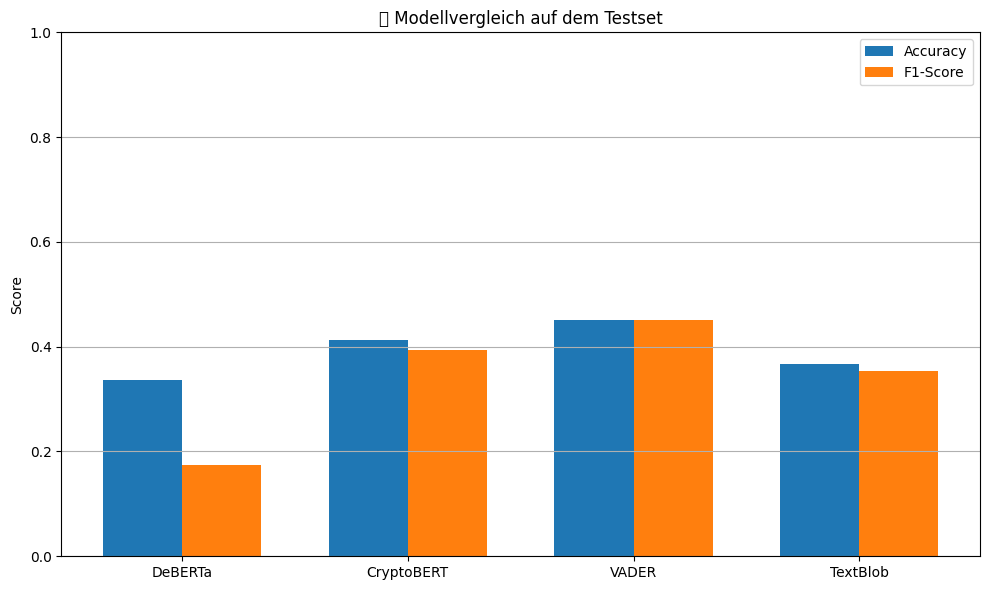

In [31]:
plot_results(plot_results_data)
